# Constrainted inpainting with generative diffusion models

In [1]:
%cd /home/hess/projects/constrained-generation/
%load_ext autoreload
%autoreload 2

/home/hess/projects/constrained-generation


In [2]:
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import Image, display

from models.config import read_yaml
import models.xarray_utils as xu
from models.simulation import Simulation, SamplingConfig
from models.guidance import Guidance, Constraint

In [108]:
def get_masked_data(x: torch.Tensor, mask_prob: float = 0.5) -> torch.Tensor:
    """ Randomly masks input data with NaNs.
    Args:
        x: Tensor to be masked.
        mask_prob: Probability for masking (lower values means more data masked).

    Returns:
        Masked data.
    """
    mask = (torch.rand_like(x) < mask_prob)
    x_masked = x.clone()
    x_masked[~mask] = float('nan')
    return x_masked

def plot_time_series(data, num_steps, title="", vmin=-15, vmax=15):
    plt.figure(figsize=(15,5))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i+1)
        plt.title(f"step {i+1}")
        plt.imshow(data[i], cmap="RdBu", vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(title)
    plt.tight_layout()
    plt.show()

# constrain on sparse observations

In [101]:
# initialize

diffusion_config_path = "/home/hess/projects/constrained-generation/configs/diffusion_vorticity_config.yaml"
config = read_yaml(diffusion_config_path)

# large
#config["dataset"]["dataset_path"] = "/p/tmp/hess/scratch/constrained-generation/datasets/vorticity_large_256.nc"
#config["checkpoints"]["inference_ckpt"] = "/p/tmp/hess/scratch/constrained-generation/checkpoints/dm_aq2nib68/best.ckpt"
#noise_shape = (1,1,256,256)

# small
config["dataset"]["dataset_path"] = "/p/tmp/hess/scratch/constrained-generation/datasets/vorticity_small_64.nc"
config["checkpoints"]["inference_ckpt"] = "/p/tmp/hess/scratch/constrained-generation/checkpoints/dm_90sm313k/best.ckpt"
noise_shape = (1,1,64,64)

sim = Simulation(
                config=config,
                noise_shape=noise_shape,
                variable_name="vorticity"
)

sim.initialize()

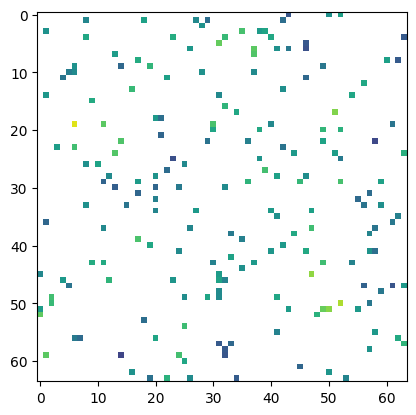

torch.Size([50, 64, 64])


In [103]:
# create dummy observations with masking

num_measurements = 50
measurements = torch.from_numpy(sim.target_test[2:num_measurements+2].values) # offset for initial conditions
masked_measurements = get_masked_data(measurements, mask_prob=0.05)
plt.imshow(masked_measurements[0], vmin=-10, vmax=10)
plt.show()

print(masked_measurements.shape)

In [110]:
# initialize constraints and run guided inference sampling

constraint = Constraint(measurement=masked_measurements,
                        loss_type="mse",
                        constraint_type="sparse")

sim.inference.guidance = Guidance(constraint=constraint,
                                  gamma=50.0,
                                  transforms=sim.transforms)
sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 20, # length of generated time series
    num_diffusion_steps = 35
)
    
results = sim.run(sampling_config)

Sample count:   0%|          | 0/20 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

In [111]:
# run inference sampling without guidance

sim.initialize()
sim.inference.guidance = None
results_no_guidance = sim.run(sampling_config)

Sample count:   0%|          | 0/20 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

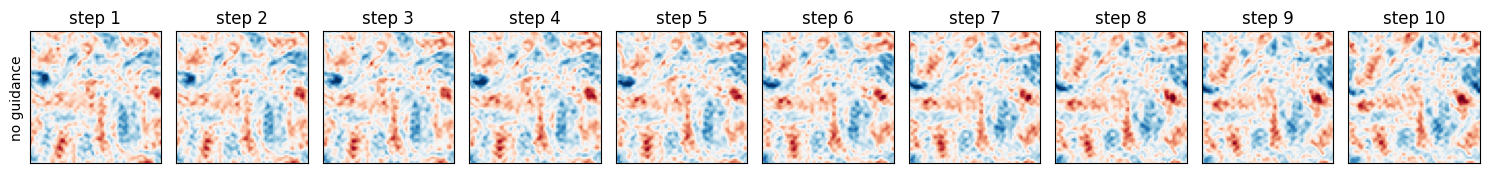

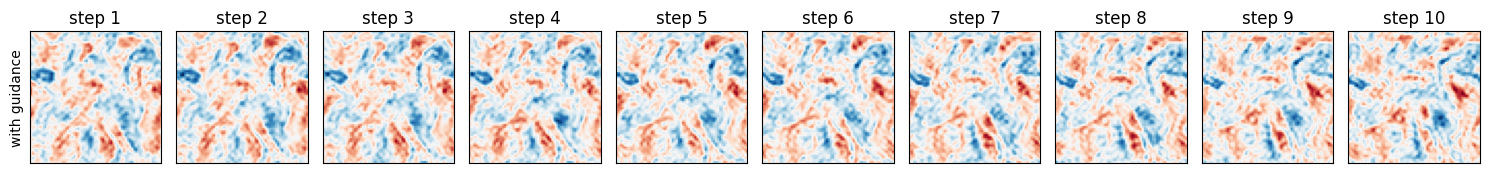

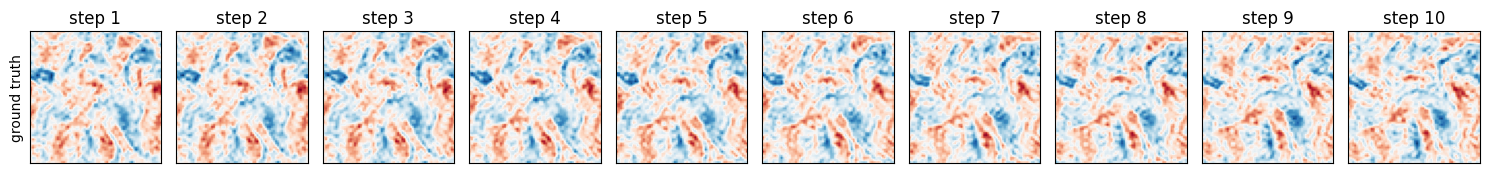

In [112]:
# compare results

num_steps = 10
start = 10

plot_time_series(results_no_guidance[start:], num_steps=num_steps, title="no guidance", vmin=-10, vmax=10)
plot_time_series(results[start:], num_steps=num_steps,  title="with guidance", vmin=-10, vmax=10)
plot_time_series(sim.target_test[2+start:], num_steps=num_steps, title="ground truth", vmin=-10, vmax=10)

# Constrain the global mean

In [21]:
# initialize

diffusion_config_path = "/home/hess/projects/constrained-generation/configs/diffusion_vorticity_config.yaml"
config = read_yaml(diffusion_config_path)

# large
config["dataset"]["dataset_path"] = "/p/tmp/hess/scratch/constrained-generation/datasets/vorticity_large_256.nc"
config["checkpoints"]["inference_ckpt"] = "/p/tmp/hess/scratch/constrained-generation/checkpoints/dm_aq2nib68/best.ckpt"
noise_shape = (1,1,256,256)

# small
#config["dataset"]["dataset_path"] = "/p/tmp/hess/scratch/constrained-generation/datasets/vorticity_small.nc"
#config["checkpoints"]["inference_ckpt"] = "/p/tmp/hess/scratch/constrained-generation/checkpoints/dm_90sm313k/best.ckpt"
#noise_shape = (1,1,64,64)

sim = Simulation(
                config=config,
                noise_shape=noise_shape,
                variable_name="vorticity"
)

sim.initialize()

In [14]:
# set up constraint

constraint = Constraint(measurement=torch.tensor([0.0], device="cuda", dtype=torch.float64).squeeze(),
                        loss_type="mse",
                        constraint_type="mean")

sim.inference.guidance = Guidance(constraint=constraint,
                                  gamma=5000.0,
                                  transforms=sim.transforms)

In [15]:
# run constrained inference

sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 10, # length of generated time series
    num_diffusion_steps = 35,
)
    
results = sim.run(sampling_config)

Sample count:   0%|          | 0/10 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

In [22]:
# run inference without constraints

sim.inference.guidance = None
sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 10,
    num_diffusion_steps = 35,
)
    
results_no_constraint = sim.run(sampling_config)

Sample count:   0%|          | 0/10 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/35 [00:00<?, ?it/s]

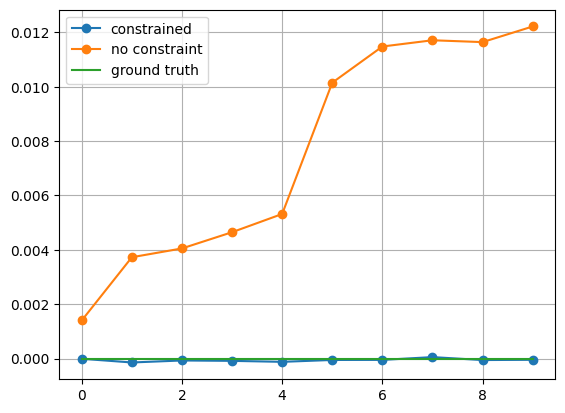

In [23]:
plt.plot(results.mean(dim=("latitude", "longitude")), marker="o", label="constrained")
plt.plot(results_no_constraint.mean(dim=("latitude", "longitude")), marker="o", label="no constraint")
plt.plot(sim.target_test[:len(results)].mean(dim=("latitude", "longitude")), label="ground truth")
plt.legend()
plt.grid()

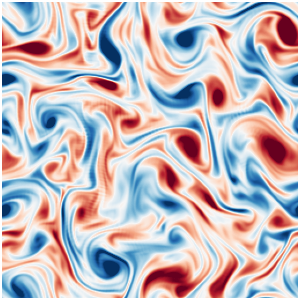

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6, 6), constrained_layout=True)
def update(i):
    cmap='RdBu'
    
    ax.imshow(results[i],vmin=-10, vmax=10, origin='lower', cmap=cmap)
    ax.set_axis_off()
update(1)

num_rollout_steps = sampling_config.num_rollout_steps
#output_filename = '/p/tmp/hess/scratch/constrained-generation/results/generated_turbulence.gif'
output_filename = '/p/tmp/hess/scratch/constrained-generation/results/generated_turbulence_large.gif'
anim = FuncAnimation(fig, update, frames=np.arange(0, num_rollout_steps), interval=250, repeat=False)
anim.save(output_filename, dpi=50)
plt.close()

display(Image(filename=output_filename))